In [13]:
import warnings
warnings.filterwarnings("ignore", message="Unable to import Axes3D")

import numpy as np
import matplotlib.pyplot as plt

#### Use LaTeX and set larger fonts


In [14]:
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 20,       # default font size
    "axes.titlesize": 20,  # title font
    "axes.labelsize": 20,  # x/y labels
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 20
})

#### Unbiased autocorrelation function using FFT

In [15]:
def autocorr(x):
    n = len(x)
    x = x - np.mean(x)
    f = np.fft.rfft(x, n=2*n)
    ac = np.fft.irfft(f * np.conjugate(f), n=2*n)[:n]
    ac /= (n - np.arange(n))
    return ac

#### User input

In [16]:
fname = "forces_wall.dat"   # your LAMMPS output file
T = 300.0                   # temperature in K
Lx = 30.0                   # box x length in Å
Ly = 30.0                   # box y length in Å

#### LAMMPS real units conversions

In [17]:
kB_SI = 1.380649e-23        # Boltzmann constant
NA = 6.02214076e23          # Avogadro constant
CF = 4184.0 / (NA * 1e-10)  # convert N <-> (kcal/mol/Å)
A_SI = Lx * Ly * 1e-20      # wall area in m2

#### Load data

In [18]:
data = np.loadtxt(fname, comments='#')
time = data[:,0]    # fs
Fx = data[:,1]      # kcal/mol/A
Fy = data[:,2]      # kcal/mol/A

#### Subtract mean to get fluctuations

In [19]:
Fx -= Fx.mean()
Fy -= Fy.mean()

#### Sampling interval from fs to seconds

In [20]:
dt_fs = np.mean(np.diff(time))
dt_SI = dt_fs * 1e-15

#### Autocorrelation function

In [21]:
C_x = autocorr(Fx)
C_y = autocorr(Fy)
C_par = 0.5 * (C_x + C_y)  # average tangential directions

#### Plot correlation for inspection

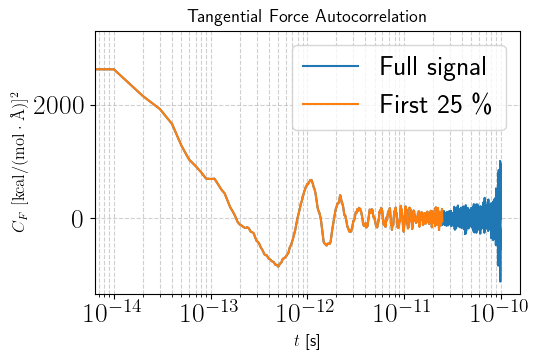

In [22]:

plt.figure(figsize=(6,4))

# Main curve
plt.semilogx(np.arange(len(C_par)) * dt_SI, C_par, "-", label="Full signal")

# Limited integration region (first 25%)
Nint = int(len(C_par) * 0.25)
steps = np.arange(Nint)
time = steps * dt_SI
plt.semilogx(time, C_par[:Nint], "-", label=r"First 25 \%")

# Labels with LaTeX formatting
plt.xlabel(r"$t$ [s]", fontsize=12)
plt.ylabel(r"$C_F$ $[\mathrm{kcal}/(\mathrm{mol}\cdot \mathrm{\AA})]^2$", fontsize=12)
plt.title(r"Tangential Force Autocorrelation", fontsize=13)

# Add legend and grid for clarity
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)

plt.tight_layout()
plt.show()

#### Integrate autocorrelation using trapezoid

In [23]:
integral_kcal_mol_A = np.trapz(C_par[:Nint], dx=dt_SI)  # (kcal/mol/Å)^2 * s

#### Convert to SI, calculate friction coeff

In [24]:
integral_SI = (CF**2) * integral_kcal_mol_A  # N²·s
lam = integral_SI / (A_SI * kB_SI * T)        # kg/(m²·s) = Pa·s/m
print(f"Friction coefficient λ = {lam:.3e} kg/(m²·s)")

Friction coefficient λ = 2.406e+06 kg/(m²·s)


#### Approximative viscosity for water

In [27]:
eta = 1e-3         # Pa·s (example)

#### Slip length


In [28]:
b = eta / lam                 # meters
print(f"Slip length b = {b:.3e} m = {b*1e9:.3f} nm")

Slip length b = 4.156e-10 m = 0.416 nm
